# Evaluation criteria

[x] Did the EDA investigation use visualisation?

[x] Does the data ingestion exist in a function or script to facilitate automation?


# Request

Recently at AAVAIL there has been discussion among management about different **approaches to revenue generation**. AAVAIL launched using a tiered, subscription-based service which showed promise, but conversations with users, especially those outside of US markets, prompted an experiments using an *à la carte* approach. This experiment was carried out mostly outside of the US an there are now a couple of years of data with a few thousand active users.

The **data** are **transaction-level purchases** across **38 different countries** and are **invoiced in batches**. Management has nearly decided to make the switch to the new model, but they find it difficult to predict monthly revenue.

They have asked you to create a **service** that, at **any point in time**, will **predict the revenue** for the **following month**. They have also asked that the service be given the ability to project revenue for a **specific country**. To keep the development time reasonable you have been advised to **limit your model** to the **ten countries with the most revenue**.

The following questions used to structure the given information:

- **Who's requesting the analysis?** AAVAIL product managers
- **What's the motive?** The managers are unsure whether they want to switch from a subscription-based service to an *à la carte* approach. They use custom revenue projection models to guide their decisions but want to spend less time on this task, and expect your results to be more accurate than theirs.
- **What's the request?** The managers have asked you to create a service that, at any point in time, will predict the revenue for the following month at the country level for the top ten countries with the most revenue.
- **What decision will be made?** AAVAIL product managers will use the revenue projections to decide whether they switch from the subscription-based to an *à-la-carte* service in a certain country. Moreover, they intend to use the prediction service for staffing and budget decisions.
- **Do we have the required data?** The available data are transaction-level purchases across 38 different countries with the parameters country, customer_id, price, stream_id, times_viewed, year, month, and day. The data is appropriate to construct a predictive model for the revenue generated monthly by the *à la carte* service on a country level. However, it is insufficient to answer the question whether the *à la carte* approach is superior to the subscription-based service. For this we would need data of a similar kind generated by an A/B test or at least some data about the subscription-based service in other countries.


# Analysis plan

**Data ingestion**

[x] Build a data ingestion pipeline that constructs a pandas data frame from the batch data

**Exploratory data analysis**
[x] *What is the business metric and how does it relate to the target variable?*  

[x] *What are the top 10 countries with the highest revenue?* Plot a bar plot to visualise the spread of total revenue, and identify the top 10 countries with the highest revenue

[x] *How do the recent views develop over time for the top 10?* For the top 10, plot `recent_views` and `total_views` in a line graph, have a vertical bar at the first of each month. Describe patterns that you can see like periodicity or differences between weekdays and the weekend

[x] *How do the recent invoices develop over time for the top 10?* Plot `recent_invoices` and `unique_invoices`in a line graph, have a vertical bar at the first of each month. Describe patterns that you can see like periodicity or differences between weekdays and the weekend

[x] *Are there any patterns in the revenue data?* To reveal this, plot all the available aggregation levels of the revenue

[x] *Is the target variable affected by any of the past revenues at specific time lags?* Plot an [autocorrelation plot](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/) of the revenue and identify time lags with a high correlation

[x] *Is the target variable affected by any of the input variables?* Plot a cross correlation matrix of the target variable `next_months_revenue` and the other input variables


**Deliverable**

[x] Communicate findings in an analysis deliverable

In [21]:
import cslib as cs
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import numpy as np
import data_ingestion as di
import numpy as np
from itertools import chain
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots as tsplt
from matplotlib.lines import Line2D
from sklearn import preprocessing

In [2]:
DIR_DATA_RAW_TRAIN = os.path.join("..", "..", "data-raw-train")
DIR_DATA_PROCESSED_TRAIN = os.path.join("..", "..", "data-processed-train")
PATH_PROCESSED_DATA = os.path.join(DIR_DATA_PROCESSED_TRAIN, "processed-invoices-2017-11--2019-07.csv")
IMG_PATH = os.path.join("..", "..", "img")

In [3]:
if os.path.isfile(PATH_PROCESSED_DATA):
    df_processed = pd.read_csv(PATH_PROCESSED_DATA, index_col=0)
else:
    df_processed = di.ingest(DIR_DATA_RAW_TRAIN, PATH_PROCESSED_DATA)

In [4]:
df_processed[25:].head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views,next_months_revenue,country
25,2017-11-26,0.0,0.0,0.0,0.0,2017-11,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom
26,2017-11-27,0.0,0.0,0.0,0.0,2017-11,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom
27,2017-11-28,2953.0,154.0,1291.0,12922.0,2017-11,13281.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United Kingdom
28,2017-11-29,3217.0,125.0,1389.0,13650.0,2017-11,13222.97,13281.12,13281.12,13281.12,13281.12,0.0,5.50000,461.500000,173959.95,United Kingdom
29,2017-11-30,2911.0,144.0,1318.0,15243.0,2017-11,12941.50,26504.09,26504.09,26504.09,26504.09,0.0,9.62069,916.275862,160736.98,United Kingdom


**Features**
- `date: object` - The date
- `purchases: float64` - The number of purchases on this date
- `unique_invoices: float64` - The number of unique invoices on this date
- `unique_streams: float64` - The number of unique streas on this date
- `total_views: float64` - The total number of views on this date
- `year_month: object` - The month and year associated with the date
- `revenue: float64` - The generated revenue on this date
- `previous_x: float64` - The revenue summed up over the past $x$ days
- `previous_year: float64` - The revenue of the past year
- `recent_invoices: float64` - The average number of unique invoices per day within the past 30 days where zero entries are not taken into account
- `recent_views: float64` - The average number of total views per day within the past the past 30 days where zero entries are not taken into account
- `next_months_revenue` - The revenue 30 days from `date` (target variable)
- `country: object` - The country associated with the data

# Analysis
## Top 10 countries with the highest revenue

In [4]:
country_revenue = df_processed.groupby(by="country")["revenue"].sum()
top_ten_countries = country_revenue.sort_values(ascending = False)[:10]
top_ten_countries.name = "total_revenue"
top_ten_countries

country
United Kingdom    3343551.644
EIRE               104589.400
Germany             45651.261
France              38985.420
Norway              38326.120
Spain               15393.360
Hong Kong           14393.130
Portugal            13327.210
Singapore           12945.460
Netherlands         12296.780
Name: total_revenue, dtype: float64

In [5]:
top_ten_countries.reset_index()

,country,total_revenue
0,United Kingdom,3343551.644
1,EIRE,104589.400
2,Germany,45651.261
3,France,38985.420
4,Norway,38326.120
5,Spain,15393.360
6,Hong Kong,14393.130
7,Portugal,13327.210
8,Singapore,12945.460
9,Netherlands,12296.780


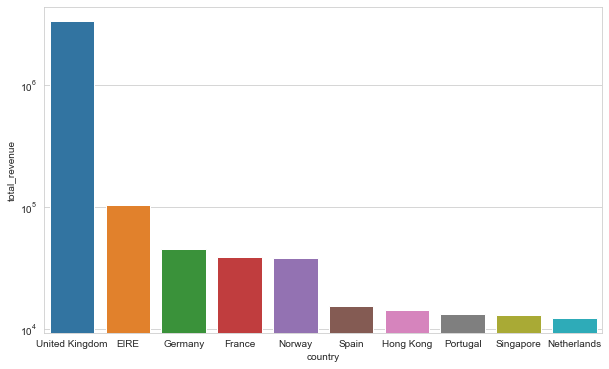

In [51]:
plt.figure(figsize=(10, 6))
g = sns.barplot(x="country", y="total_revenue", data=top_ten_countries.reset_index())
g.set(yscale="log")
plt.savefig(os.path.join(IMG_PATH, "top10_countries.png"))

The revenue of the top 10 countries is widely spread between 3343551.644 (United Kingdom)  and 12296.78 (Netherlands). 

For the remaining analysis, we split the data of the top ten countries into test and training data to avoid introducing bias.

In [6]:
df_train, df_test = di.train_test_split(df_processed[df_processed["country"].isin(top_ten_countries.index)], train_size=0.8)

In [7]:
df_train.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views,next_months_revenue,country
2972,2017-11-29,0.0,0.0,0.0,0.0,2017-11,0.00,375.99,375.99,375.99,375.99,0.0,0.107143,19.464286,4057.10,EIRE
2973,2017-11-30,33.0,1.0,33.0,192.0,2017-11,194.22,375.99,375.99,375.99,375.99,0.0,0.103448,18.793103,4057.10,EIRE
2974,2017-12-01,0.0,0.0,0.0,0.0,2017-12,0.00,570.21,570.21,570.21,570.21,0.0,0.133333,24.566667,3862.88,EIRE
2975,2017-12-02,0.0,0.0,0.0,0.0,2017-12,0.00,570.21,570.21,570.21,570.21,0.0,0.133333,24.566667,3862.88,EIRE
2976,2017-12-03,0.0,0.0,0.0,0.0,2017-12,0.00,570.21,570.21,570.21,570.21,0.0,0.133333,24.566667,3876.88,EIRE


In [8]:
df_test.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views,next_months_revenue,country
3434,2019-03-06,0.0,0.0,0.0,0.0,2019-03,0.00,236.82,374.89,1412.32,2759.80,4452.41,0.500000,109.266667,9527.31,EIRE
3435,2019-03-07,63.0,4.0,63.0,686.0,2019-03,255.57,236.82,286.82,1412.32,2759.80,4383.16,0.500000,109.266667,9527.31,EIRE
3436,2019-03-08,4.0,4.0,1.0,9.0,2019-03,6748.68,491.54,542.39,1667.89,3015.37,4194.15,0.600000,132.033333,9271.74,EIRE
3437,2019-03-09,0.0,0.0,0.0,0.0,2019-03,0.00,7004.25,7266.07,8416.57,9764.05,4194.15,0.733333,132.333333,2523.06,EIRE
3438,2019-03-10,0.0,0.0,0.0,0.0,2019-03,0.00,7004.25,7266.07,8416.57,9764.05,4019.59,0.733333,132.333333,2741.75,EIRE


## Business metric
The managers would like to know which business model is more successful (a subscription- or an *à la carte*-based service). Economical success can be measured be the return of a business model, which is given by the difference between the generated revenue and expenses. Thus, our target variable, the total revenue generated within the next month (30 days) is closely related to the business metric. The return impacts on the equity of a business, and consequently is central to make executive decisions.

## Summary statistics

In [24]:
names = ["purchases", "unique_invoices", "unique_streams", "total_views", "revenue", "previous_7", "previous_14", "previous_70", "previous_year", "recent_invoices", "recent_views", "next_months_revenue"]

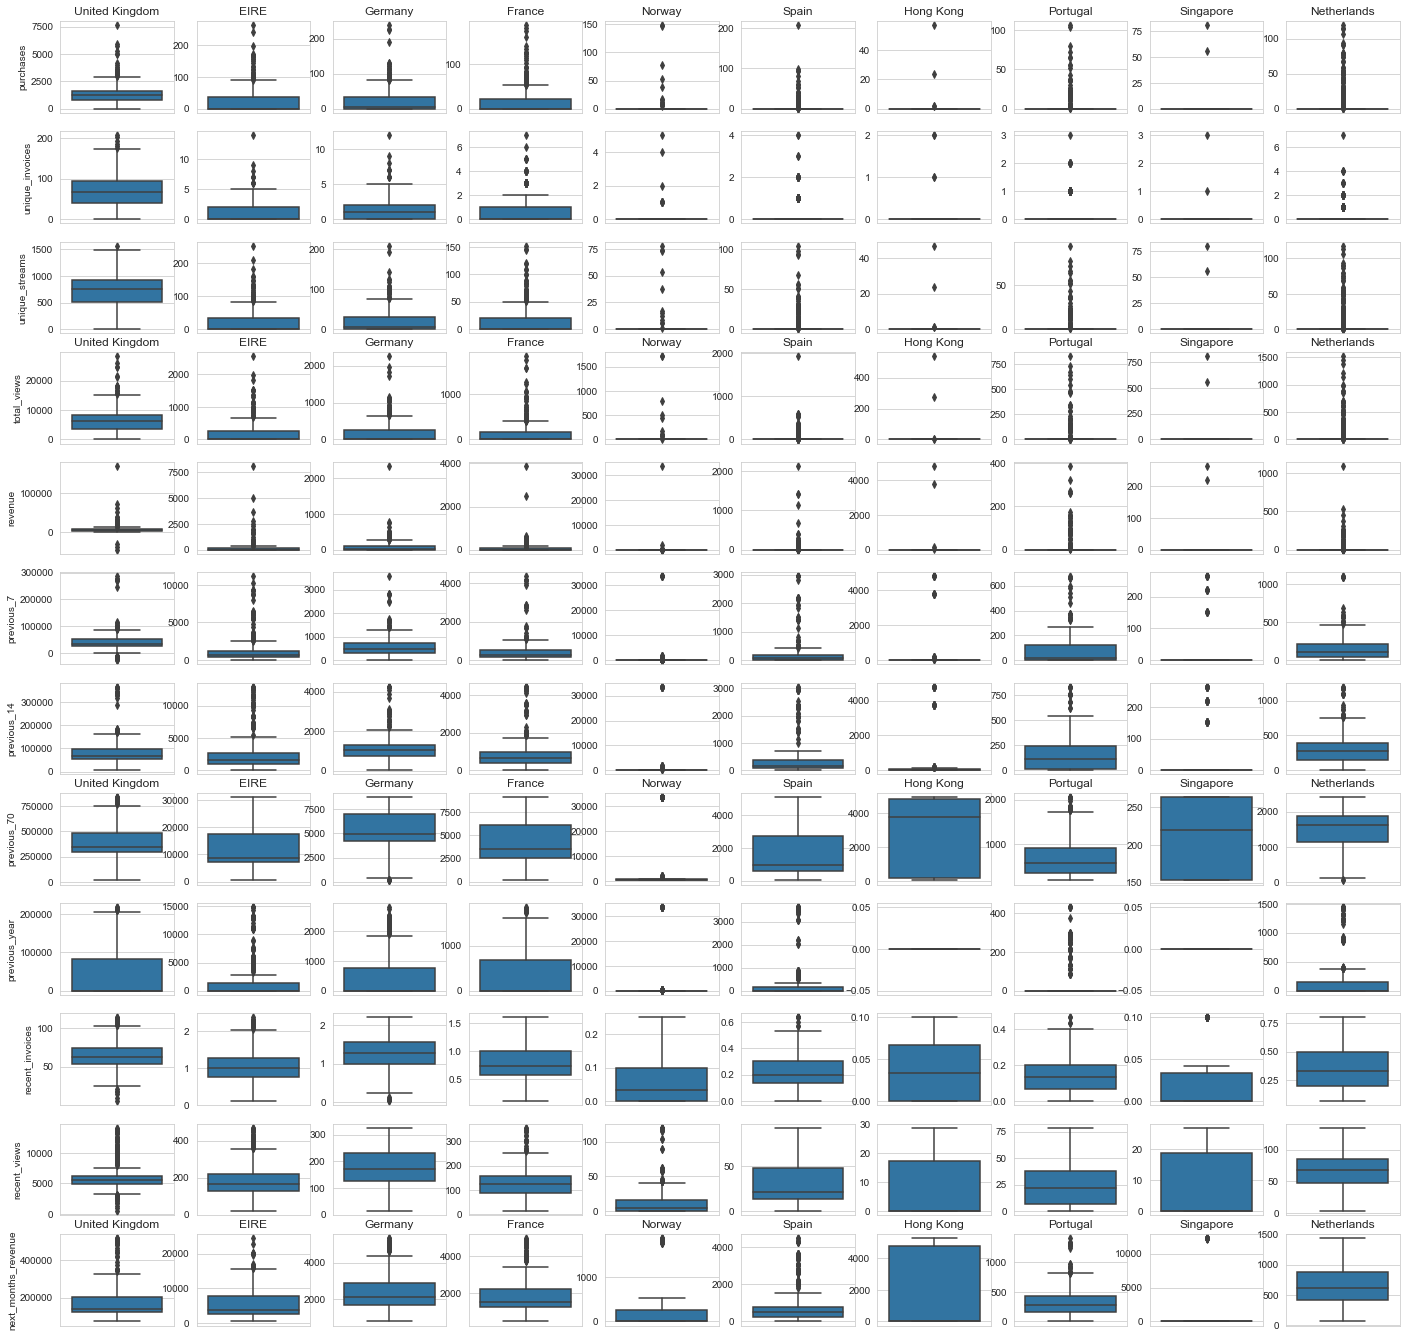

In [12]:
fig, axes = plt.subplots(len(names), len(top_ten_countries.index), figsize=(24, 24))

for i, name in enumerate(names):
    for j, country in enumerate(top_ten_countries.index):
        sns.boxplot(y=df_train[df_train["country"]==country][name], ax=axes[i][j])
        if j > 0:
            axes[i][j].set_ylabel("")
        if i in [0, 3, 7, 11]:
            axes[i][j].set_title(country)

- **purchases**:
- **unique_invoices**:
- **total_views**:
- **revenue**:
- **previous_7**:
- **previous_14**:
- **previous_70**:
- **previous_year**:
- **recent_invoices**:
- **recent_views**:
- **next_months_revenue**:

In [13]:
print("##### Number of samples in the training set for each country #####")
df_train.groupby(by="country").size()

##### Number of samples in the training set for each country #####


country
EIRE              463
France            463
Germany           463
Hong Kong         327
Netherlands       463
Norway            459
Portugal          463
Singapore         331
Spain             462
United Kingdom    463
dtype: int64

## Views over time

In [8]:
def country_lineplot(df, col_names, country, **kwargs):
    if isinstance(col_names, str):
        g = sns.lineplot(x="date", y=col_names, data=df[df["country"]==country], **kwargs)
    else:
        data = df[df["country"]==country][col_names + ["date"]].set_index("date")
        stacked_data = data.stack().reset_index().rename(columns={"level_0":"date", "level_1":"col_names", 0:"val"}).set_index("date")
        g = sns.lineplot(x="date", y="val", data=stacked_data, hue="col_names", **kwargs)
    
    plt.gcf().canvas.draw()
    # Set monthly x-ticks
    first_days = [label for label in g.xaxis.get_ticklabels() if label.get_text()[-2:]=='01']
    xticks = [t.get_position()[0] for t in first_days]
    g.set(xticks=xticks, title=country)
    g.set_xticklabels(first_days, rotation=90)
    
    return g

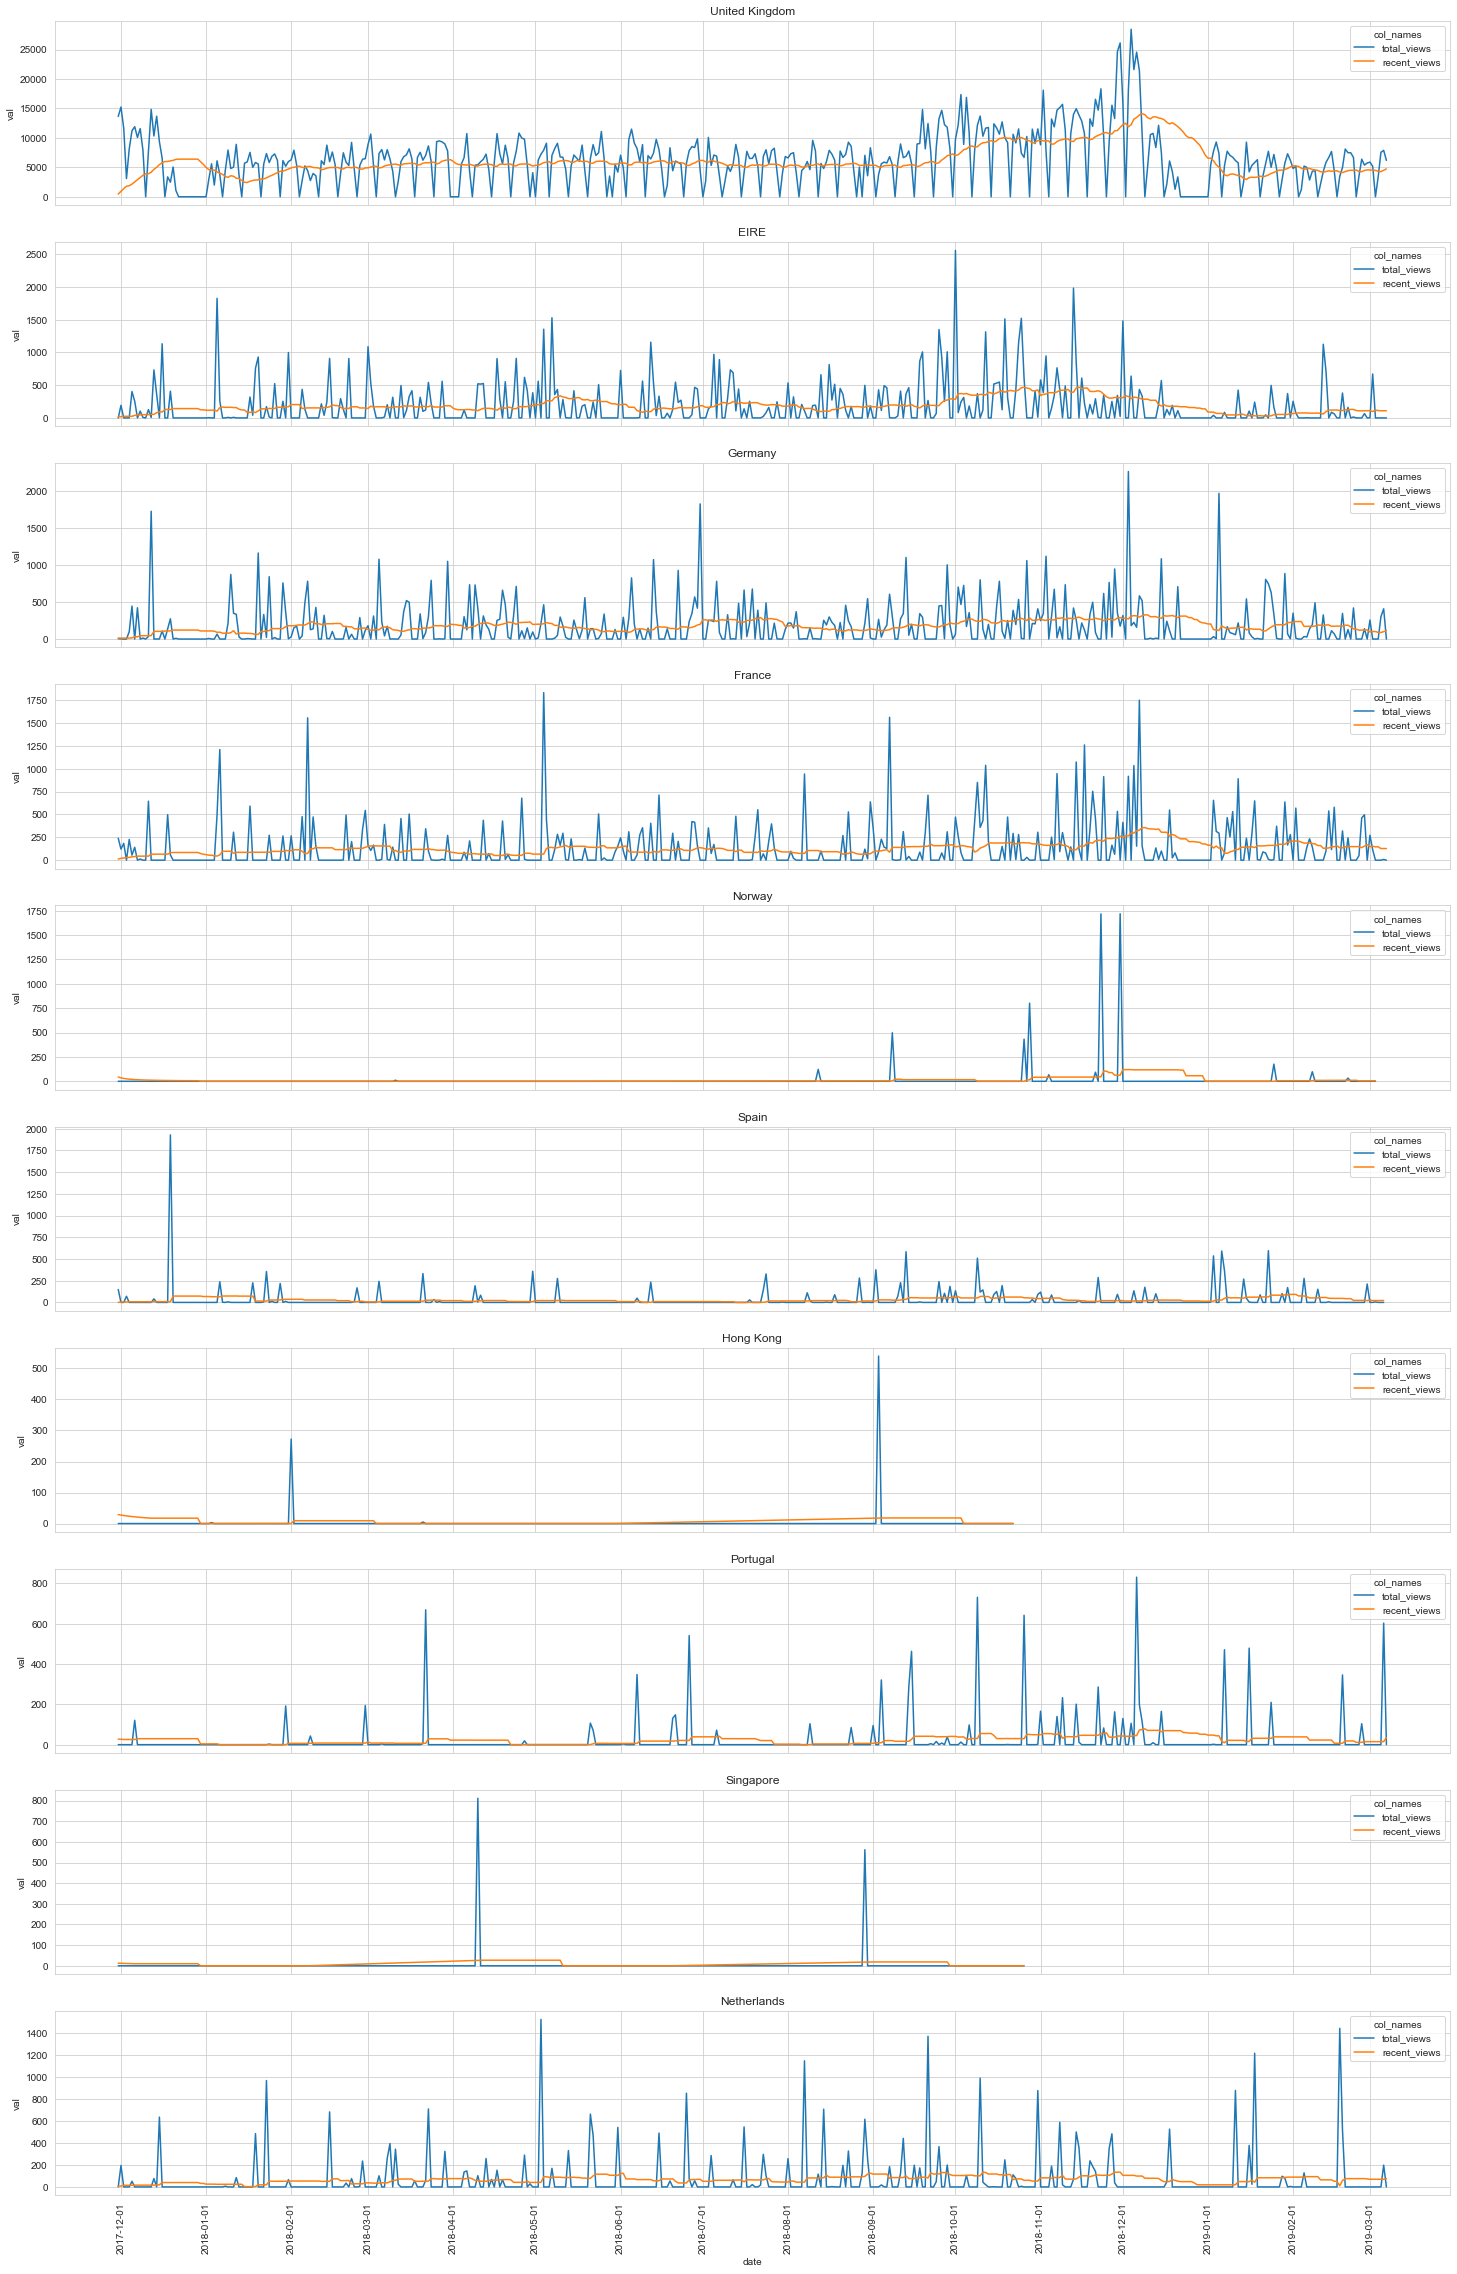

In [55]:
fig, axes = plt.subplots(len(top_ten_countries.index), 1, figsize=(25, 40), sharex=True)

for i, country in enumerate(top_ten_countries.index):
    country_lineplot(df_train, ["total_views", "recent_views"], country, ax=axes[i])
plt.savefig(os.path.join(IMG_PATH, "views_per_country.png"))

## Invoices over time

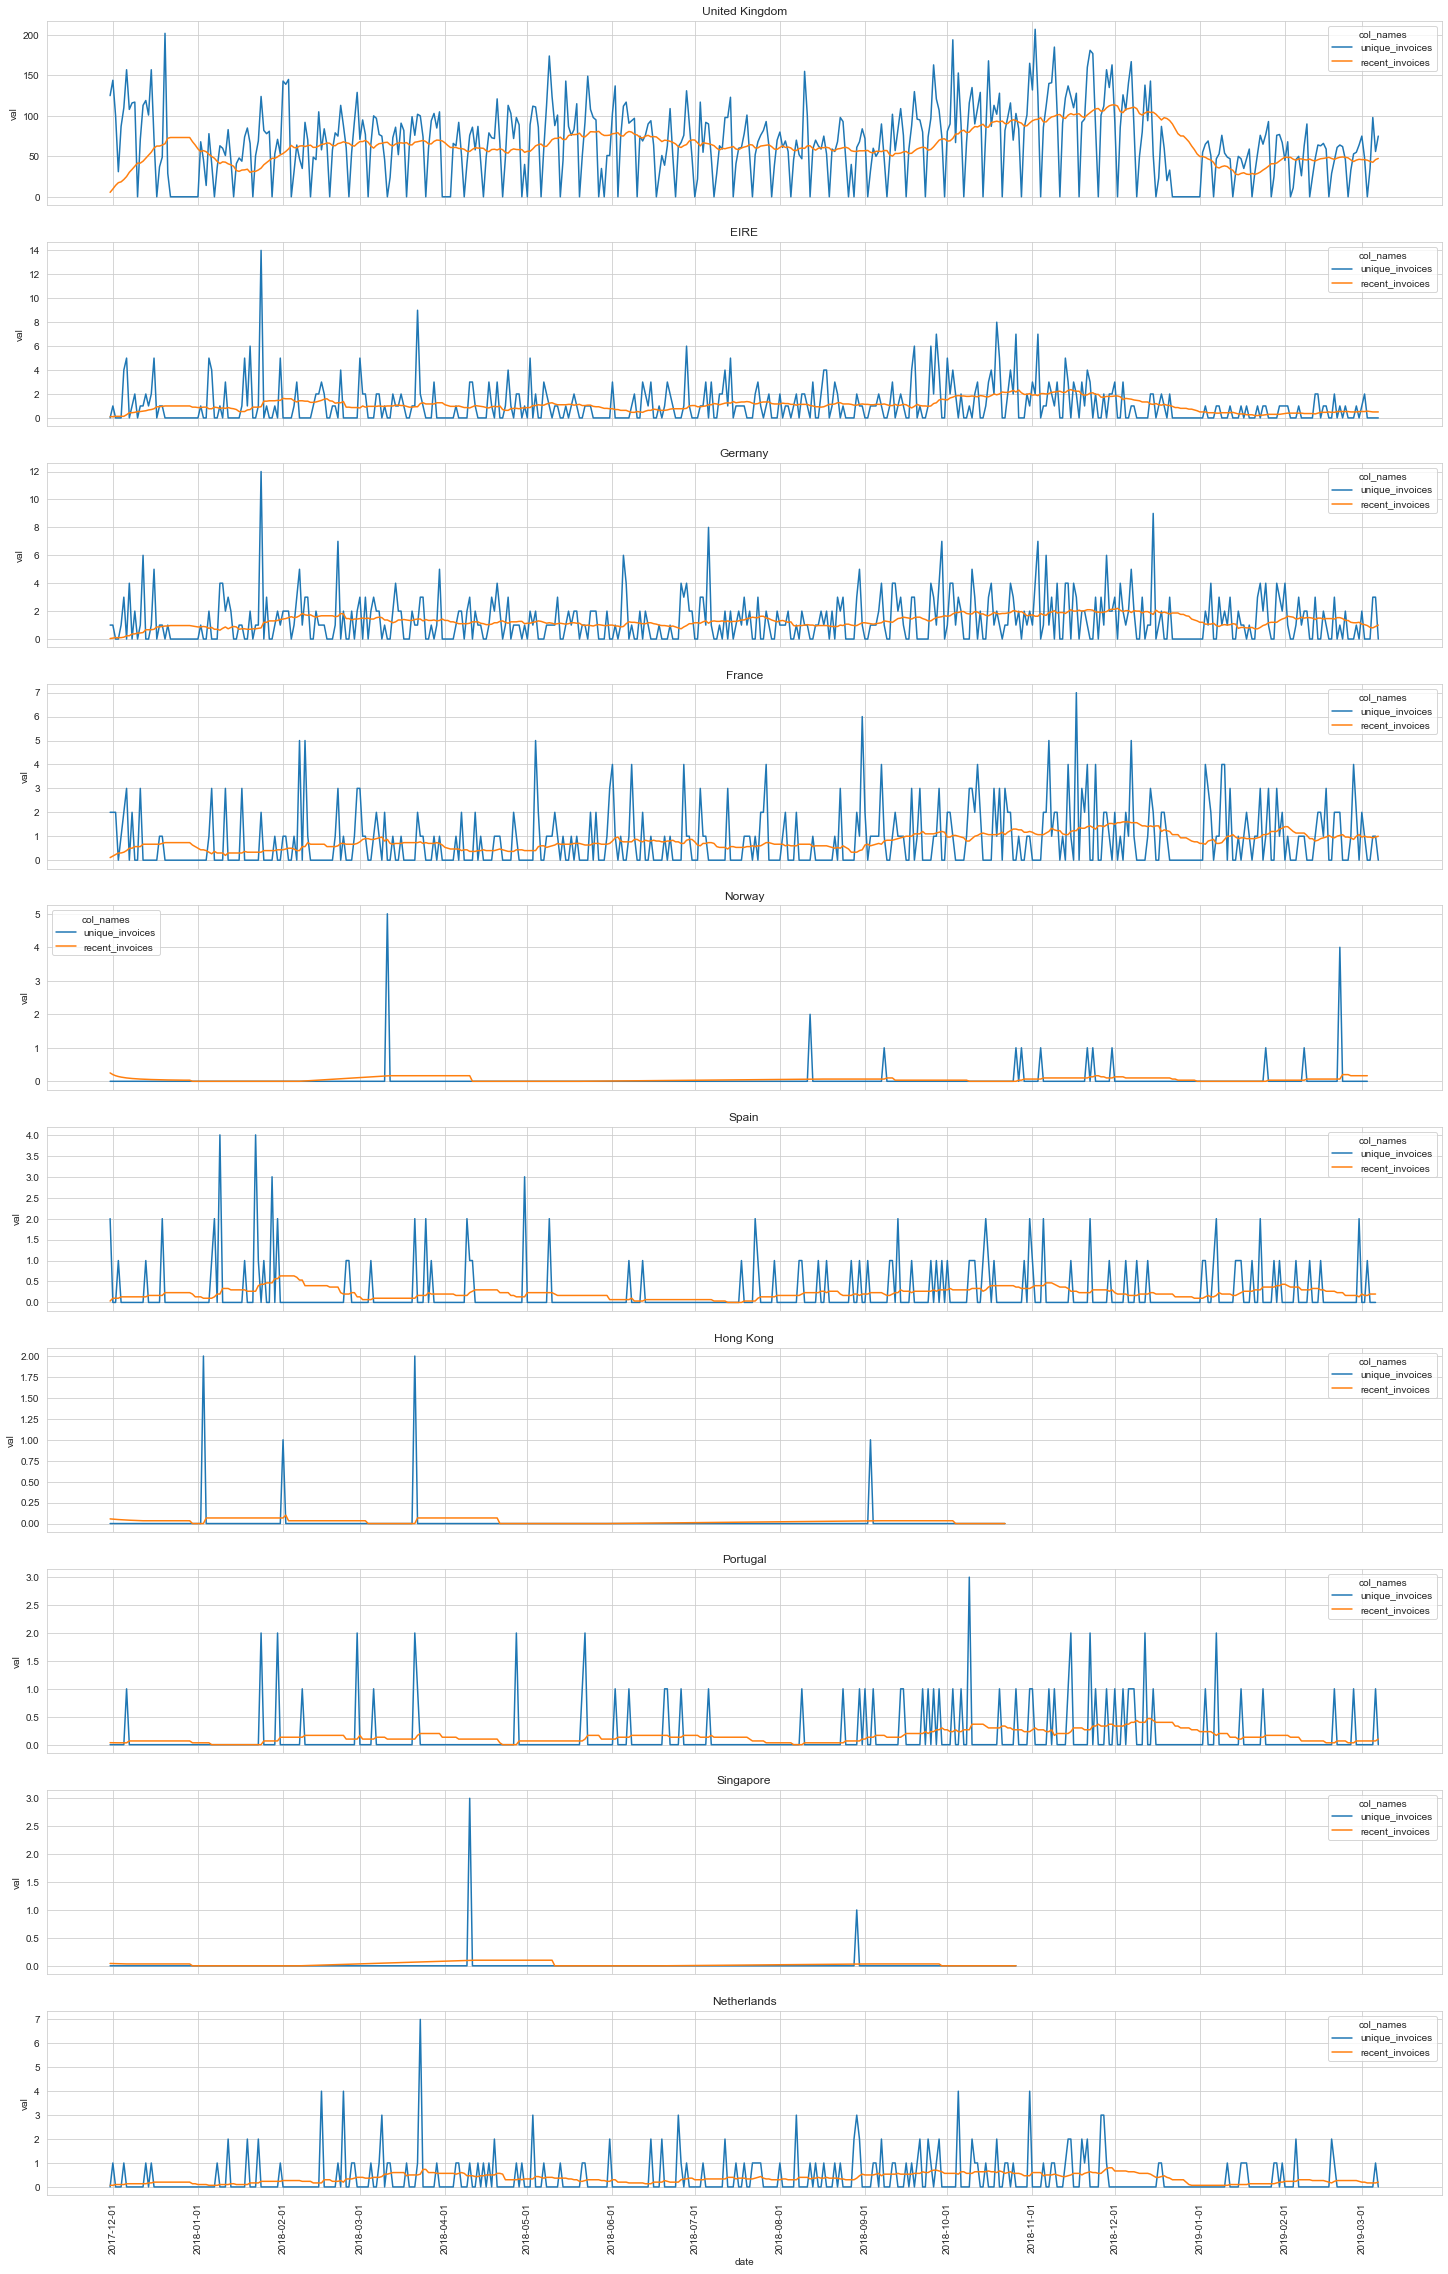

In [59]:
fig, axes = plt.subplots(len(top_ten_countries.index), 1, figsize=(25, 40), sharex=True)

for i, country in enumerate(top_ten_countries.index):
    country_lineplot(df_train, ["unique_invoices", "recent_invoices"], country, ax=axes[i])

## Revenue patterns

In [21]:
revenue_vars = ["revenue", "previous_7", "previous_14", "previous_70", "previous_year", "next_months_revenue"]

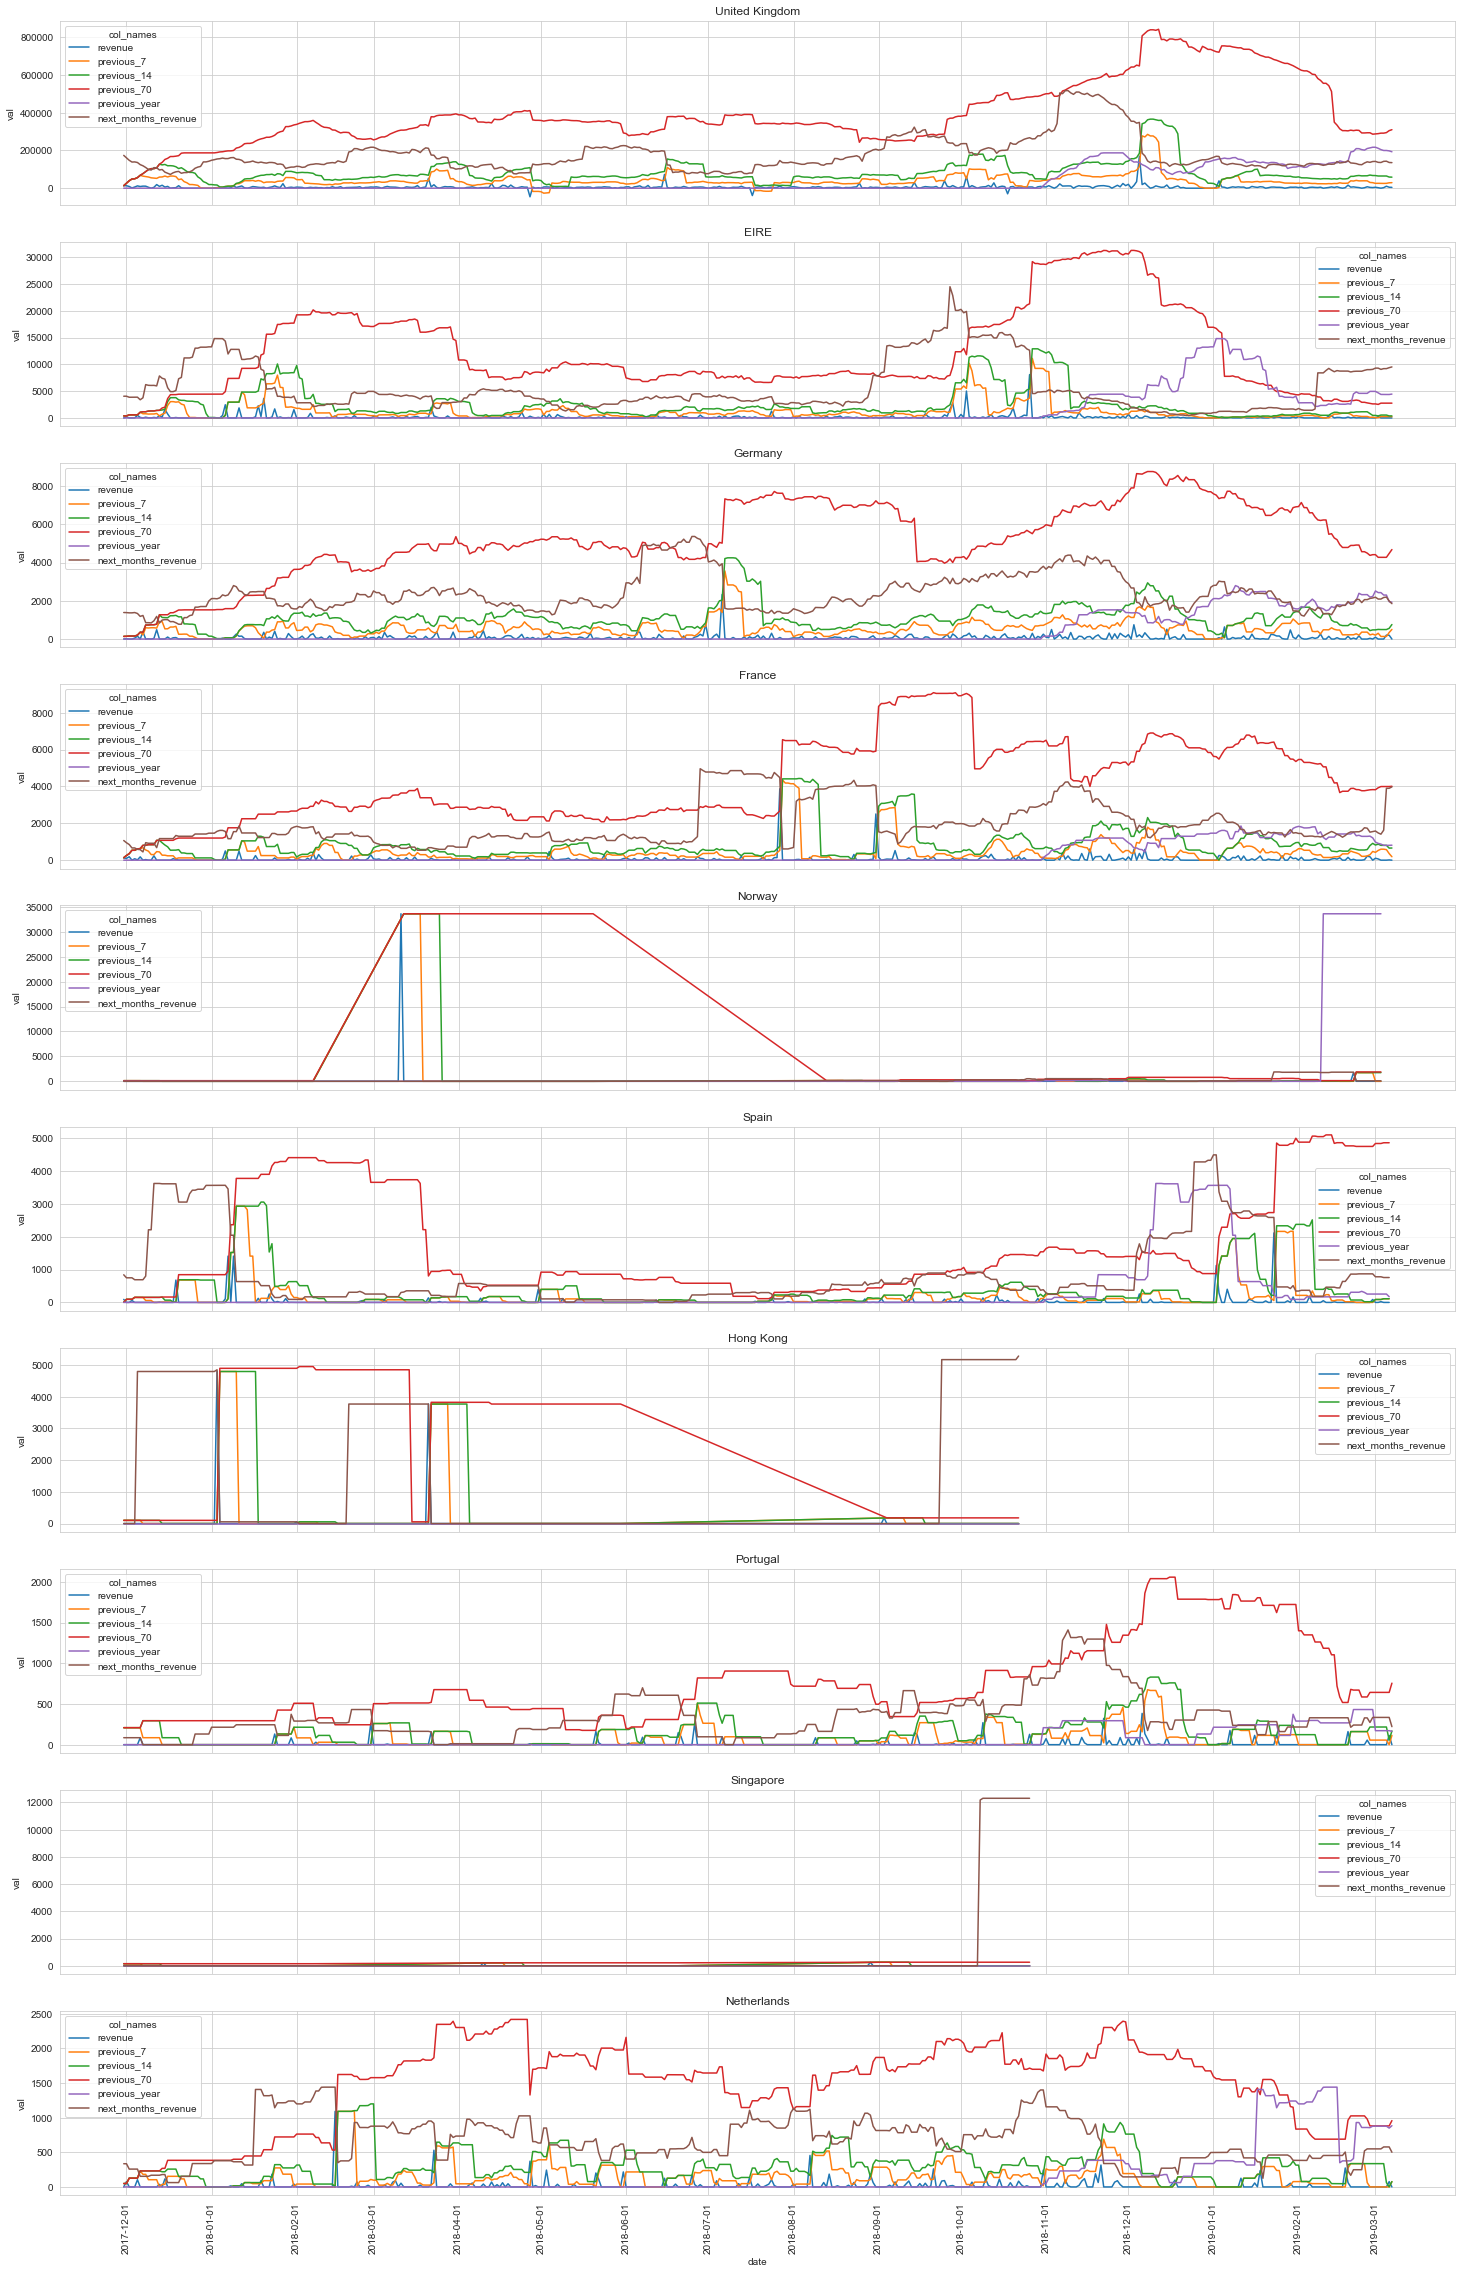

In [58]:
fig, axes = plt.subplots(len(top_ten_countries.index), 1, figsize=(25, 40), sharex=True)

for i, country in enumerate(top_ten_countries.index):
    country_lineplot(df_train, revenue_vars, country, ax=axes[i])

## Revenue in different countries

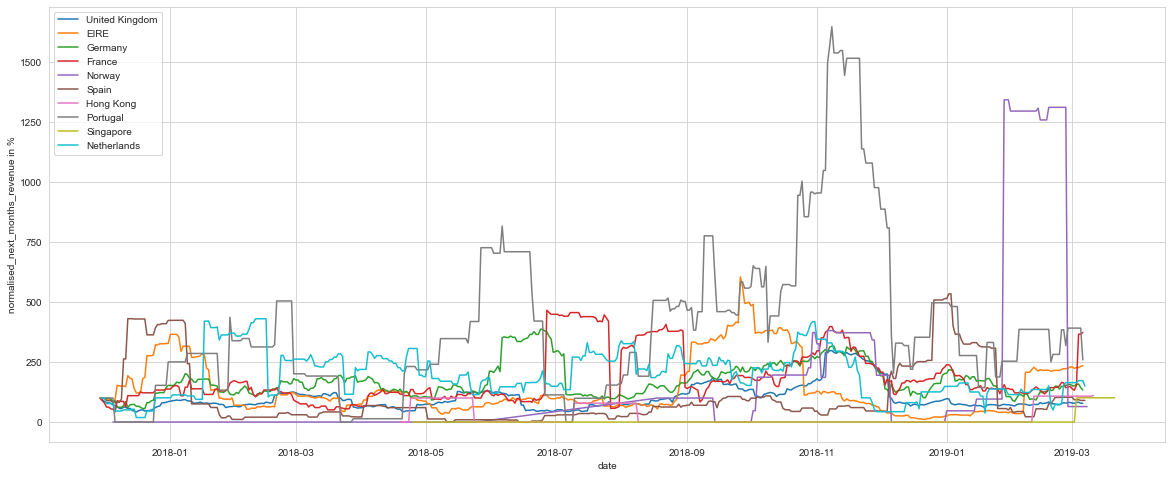

In [23]:
plt.figure(figsize=(20, 8))
for i, country in enumerate(top_ten_countries.index):
    target = df_train[df_train["country"]==country][["date", "next_months_revenue"]].sort_values("date")
    first_nonzero_nonna = target["next_months_revenue"].dropna().ne(0).idxmax()
    baseline = target["next_months_revenue"][first_nonzero_nonna]
    percentage_change = target["next_months_revenue"]/baseline*100
    percentage_change.name = "normalised_next_months_revenue in %"
    sns.lineplot(x=pd.to_datetime(target["date"]), y=percentage_change, label=country)
plt.savefig(os.path.join(IMG_PATH, "pct_change_target_per_country.png"))

## Autocorrelation and partial autocorrelation of the target variable at different time lags

ACF Plot: The autocorrleation (y-axis), which is the relationship between the series and each progressive lag (x-axis) with the series.

PACF Plot: The partial-autocorrelation vs lags. The Partial Autocorrelation shows how much each progressive ACF adds to the predictability. In other words, lags that are correlated with each other are de-weighted so the most important lags are present.

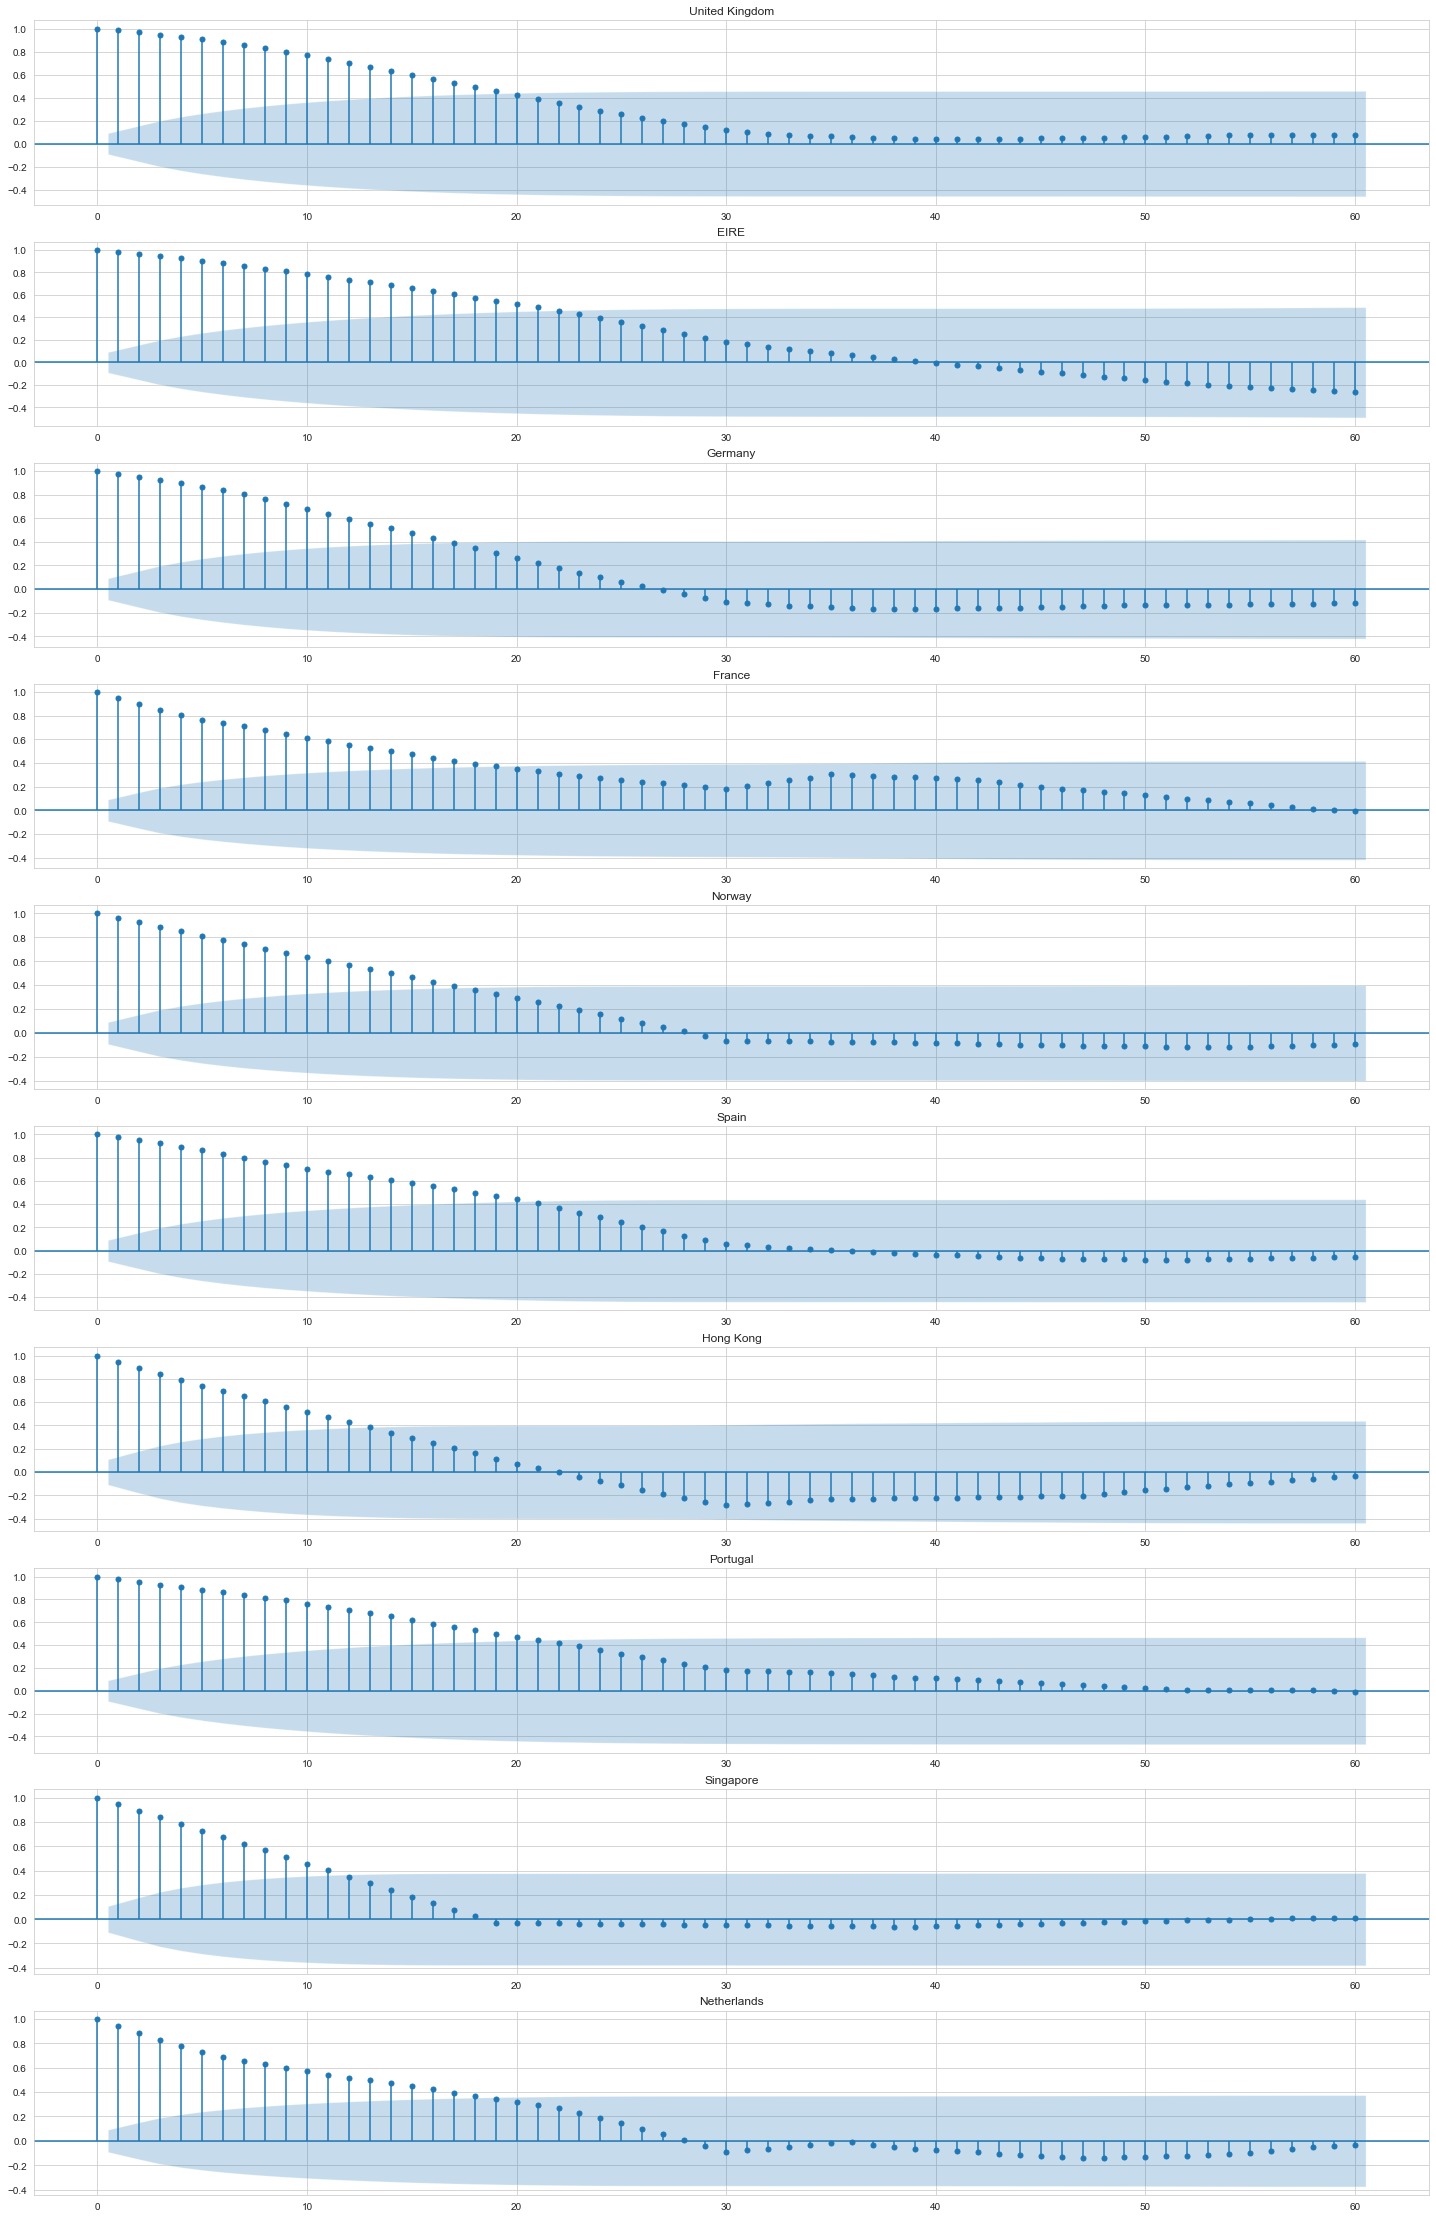

In [40]:
fig, axes = plt.subplots(len(top_ten_countries.index), 1, figsize=(25, 40))

for i, country in enumerate(top_ten_countries.index):
    tsplt.plot_acf(df_train[df_train["country"]==country]["next_months_revenue"].values.squeeze(),
                   lags=60, ax=axes[i], missing="conservative");
    axes[i].set_title(country)

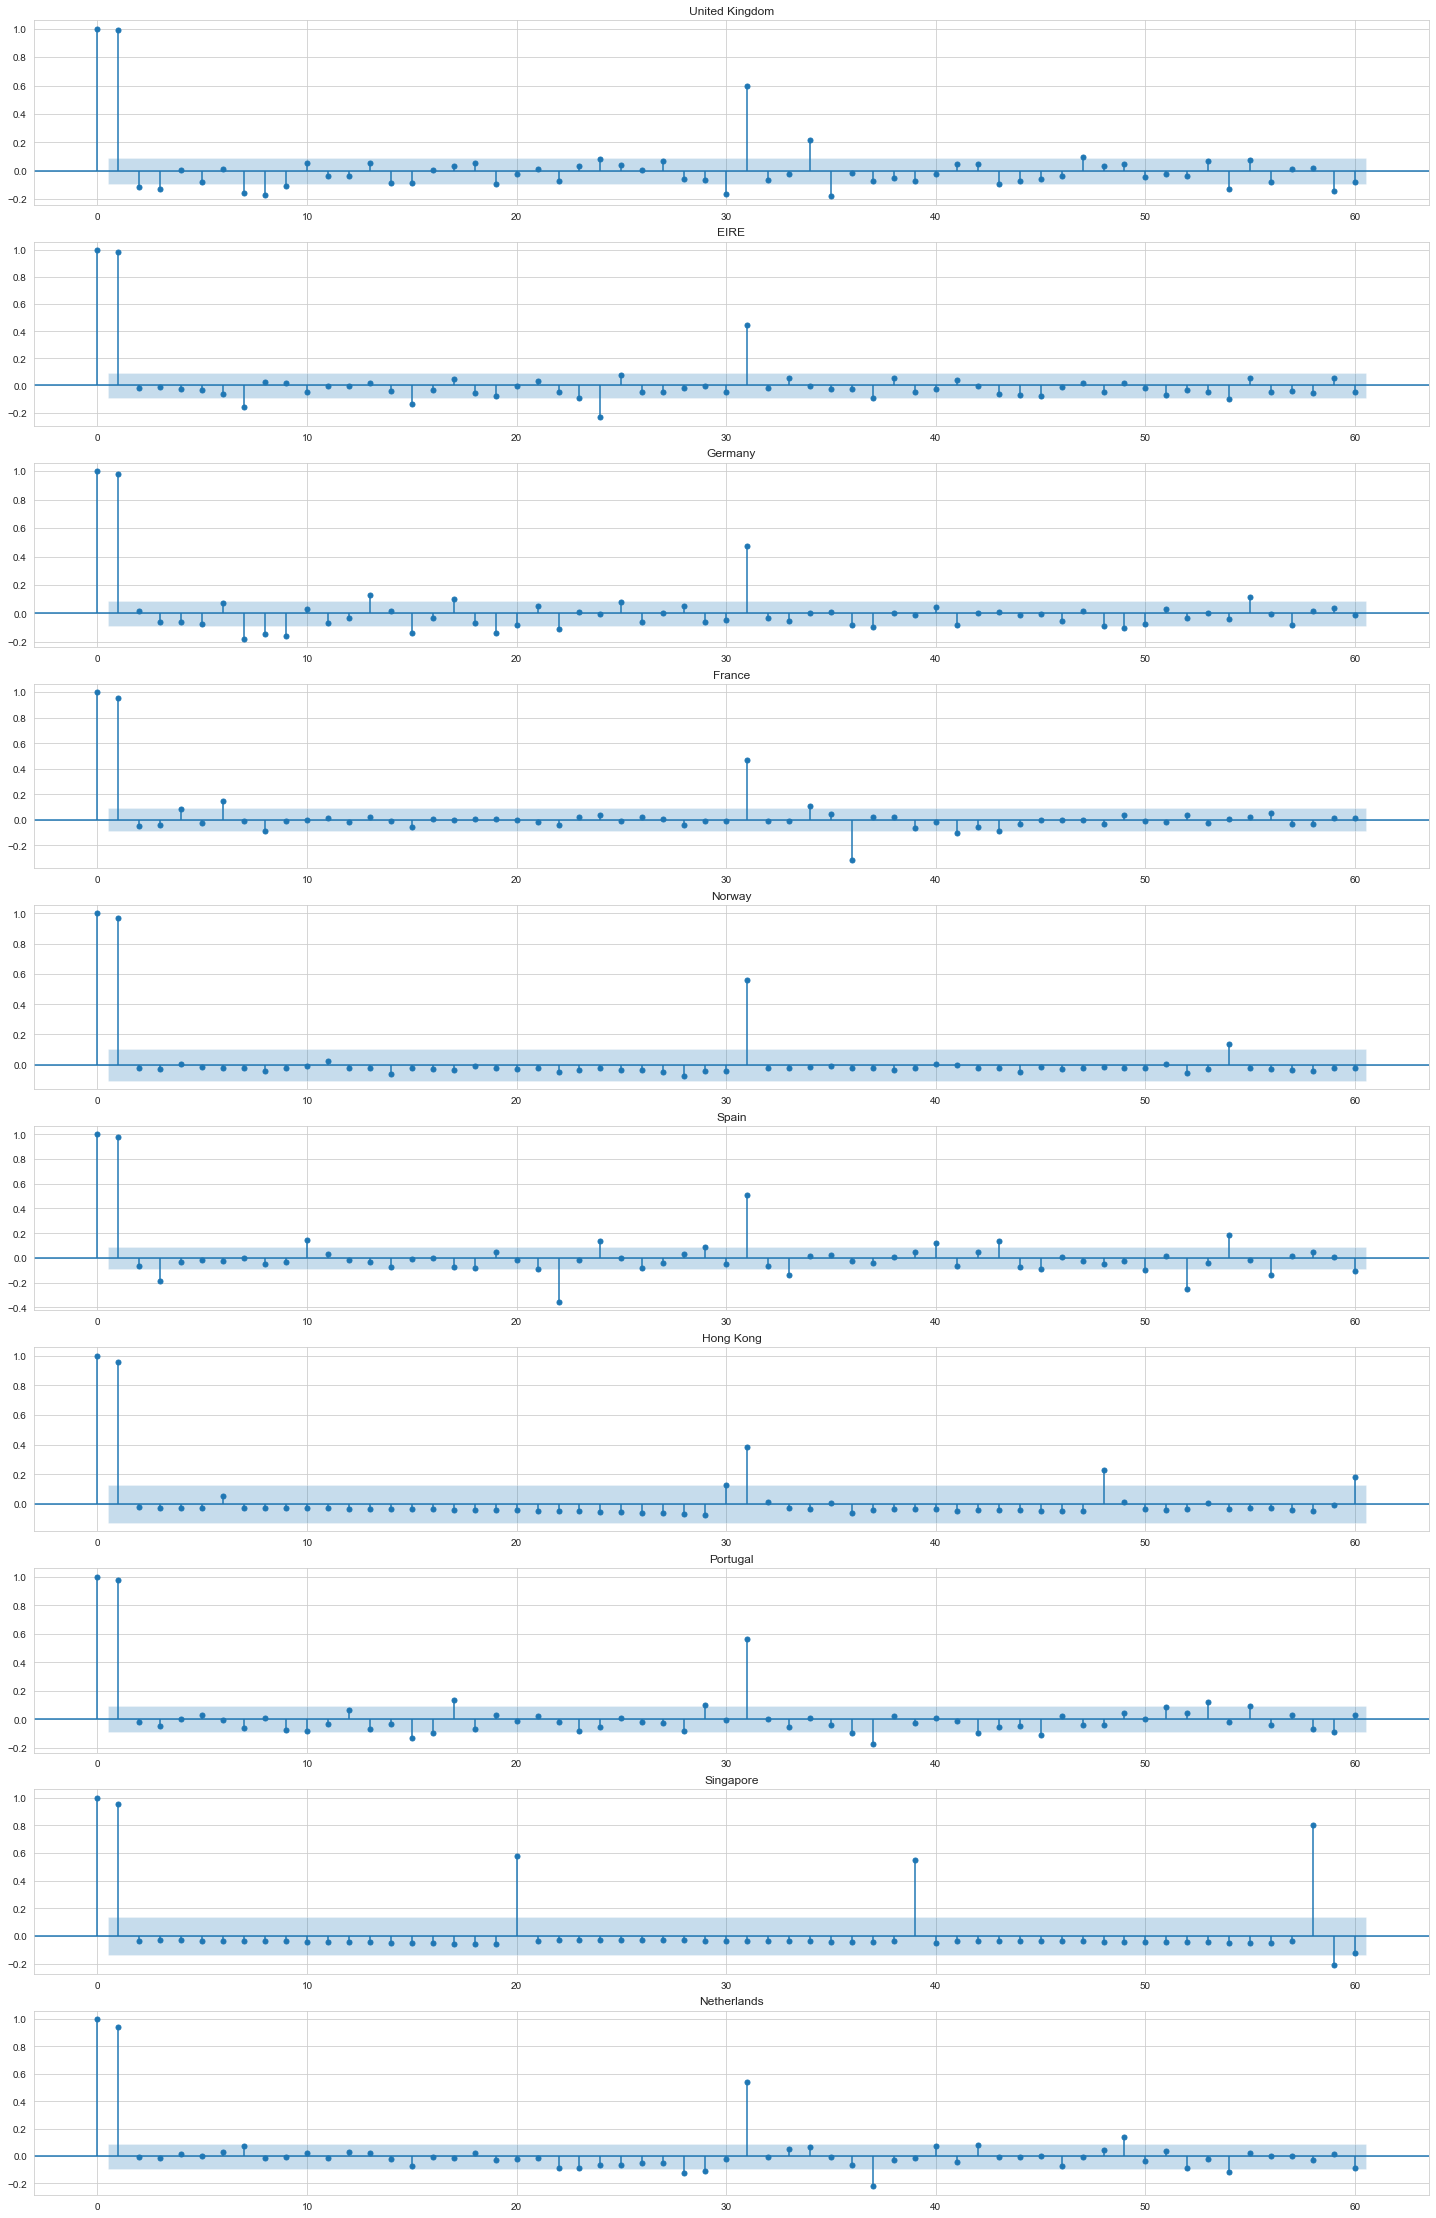

In [46]:
fig, axes = plt.subplots(len(top_ten_countries.index), 1, figsize=(25, 40))

for i, country in enumerate(top_ten_countries.index):
    tsplt.plot_pacf(df_train[df_train["country"]==country]["next_months_revenue"].dropna().values.squeeze(),
                   lags=60, ax=axes[i]);
    axes[i].set_title(country)

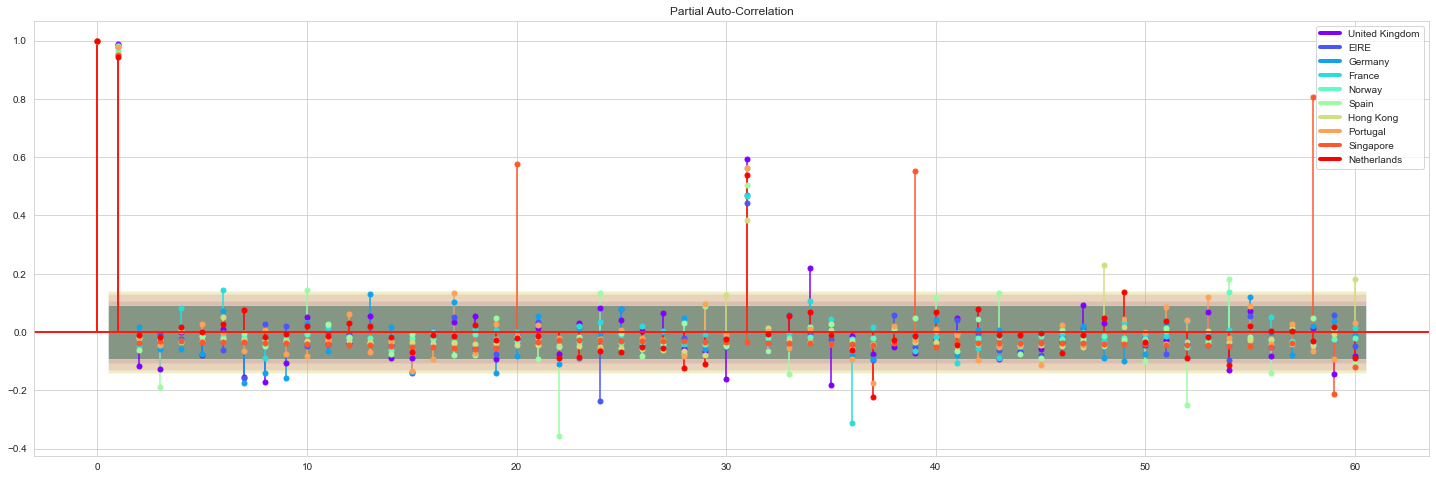

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8))
colors=plt.cm.rainbow(np.linspace(0, 1, 10))

for i, country in enumerate(top_ten_countries.index):
    tsplt.plot_pacf(df_train[df_train["country"]==country]["next_months_revenue"].dropna().values.squeeze(),
                   lags=60, ax=ax, color=colors[i], vlines_kwargs={"colors": colors[i]});
    
    
ax.set_title("Partial Auto-Correlation")    
custom_lines = [Line2D([0], [0], color=colors[i], lw=4) for i in range(10)]
ax.legend(custom_lines, top_ten_countries.index)

plt.savefig(os.path.join(IMG_PATH, "partial_autocorrelation.png"))

## Cross-correlation plot

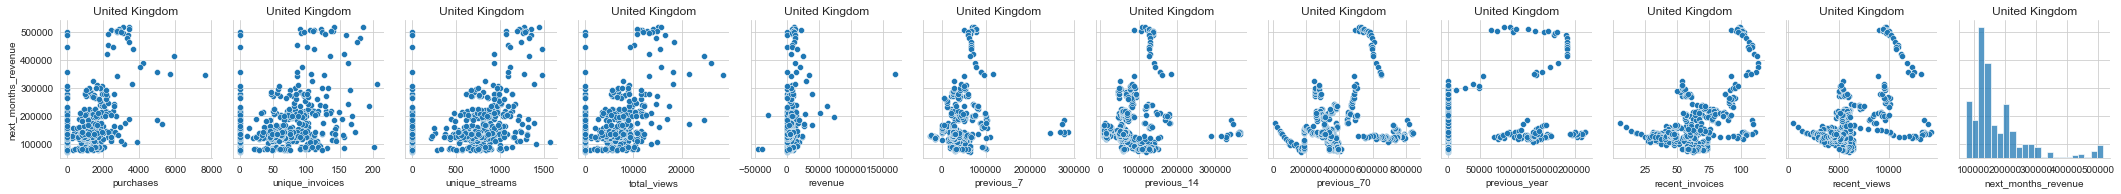

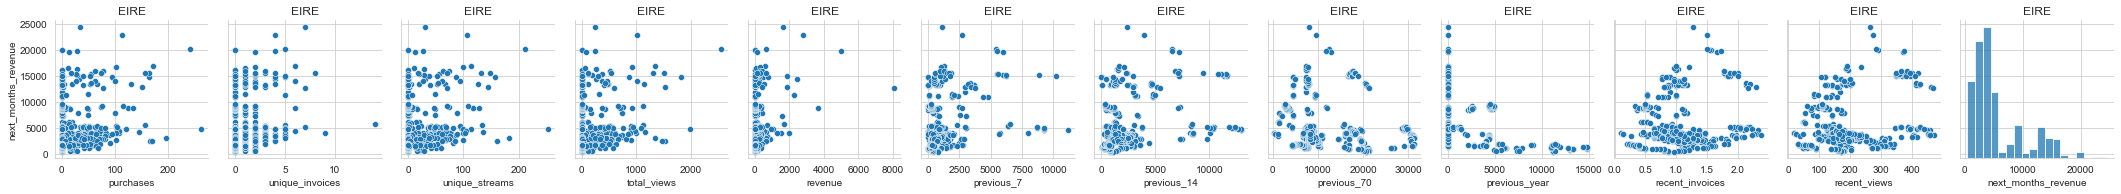

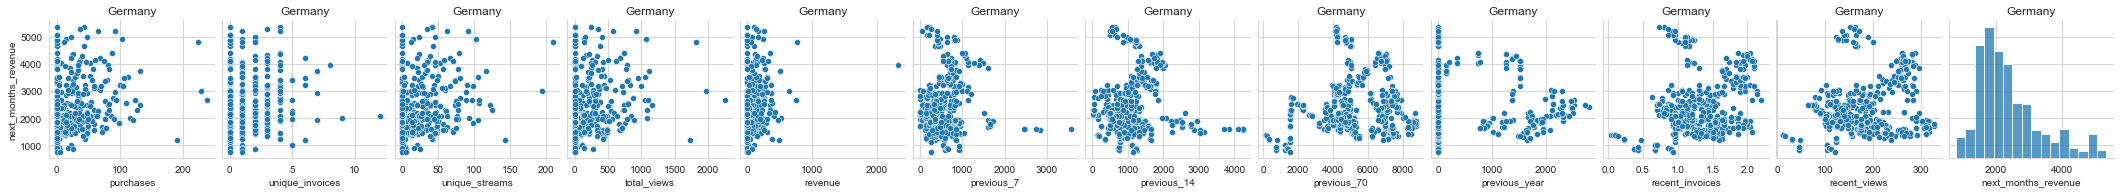

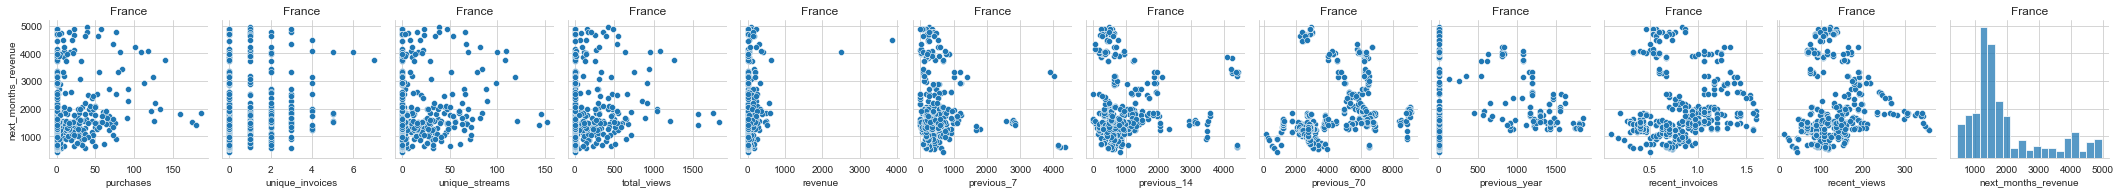

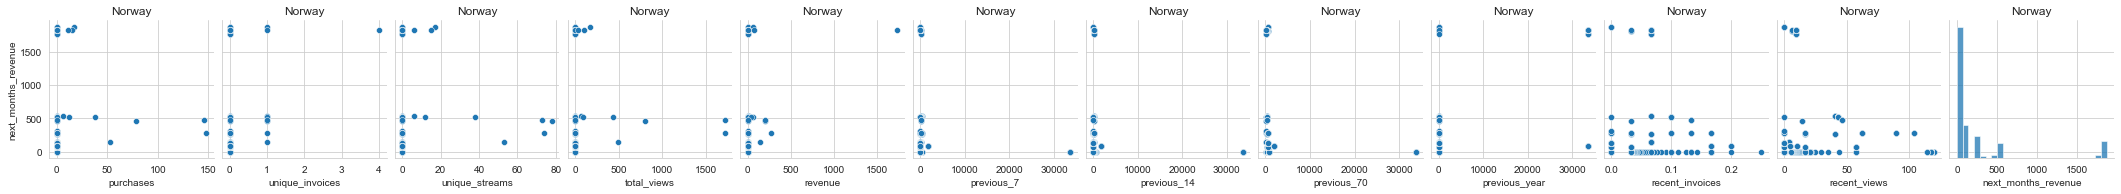

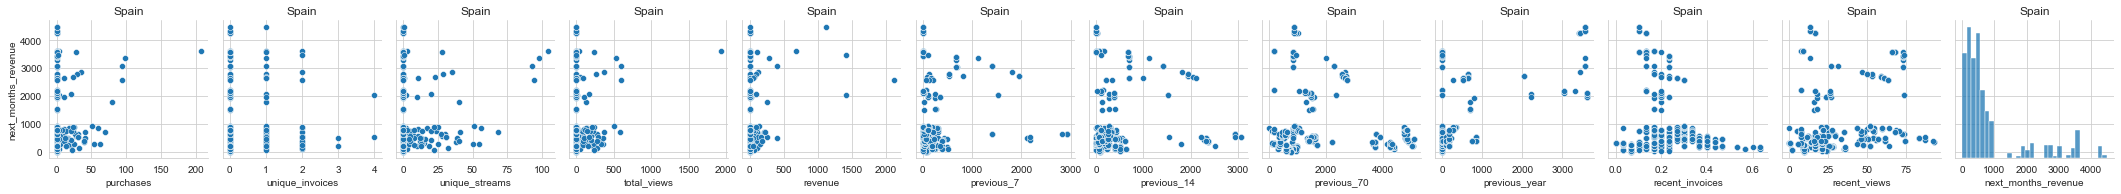

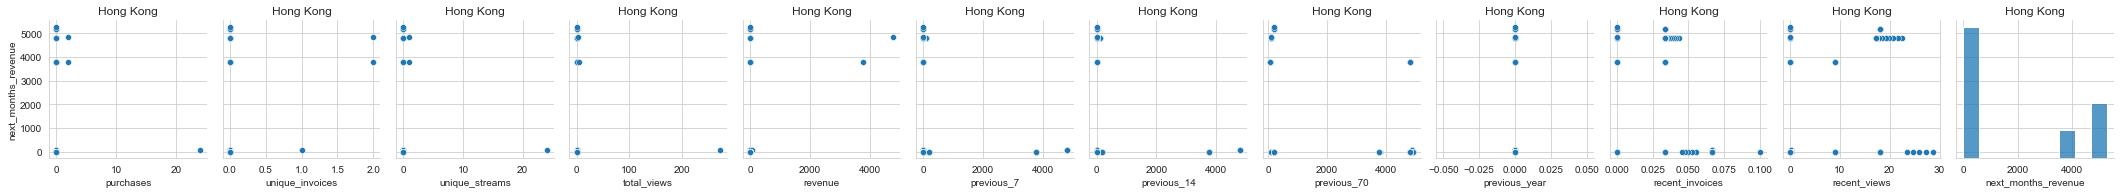

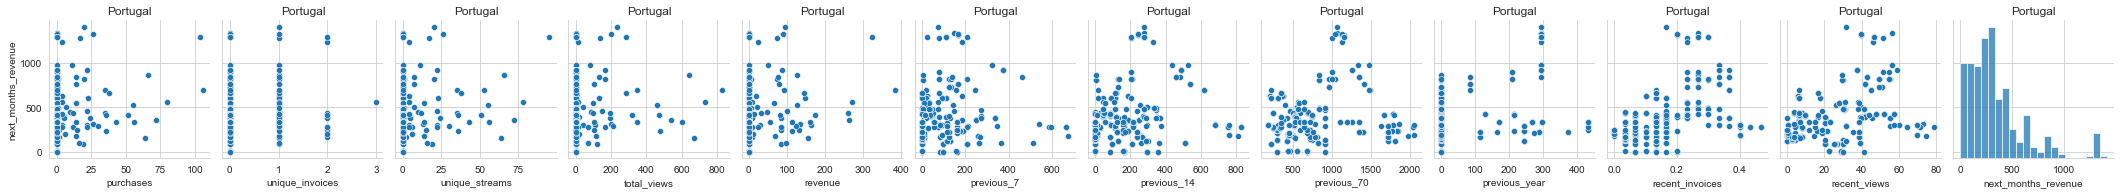

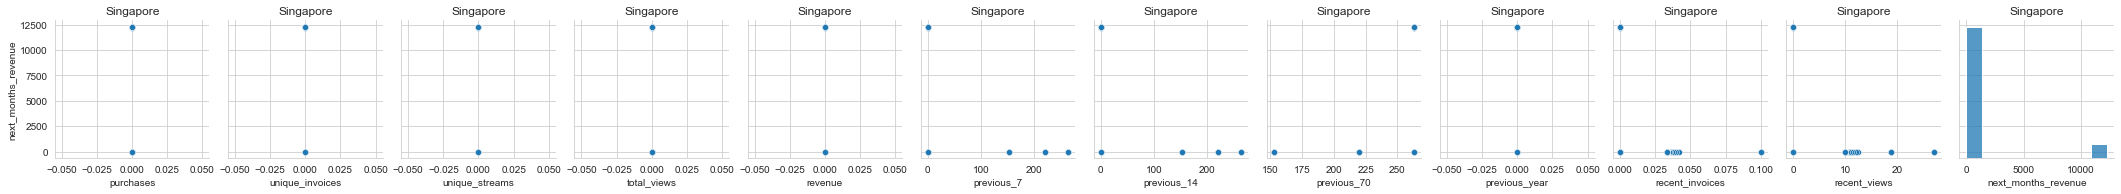

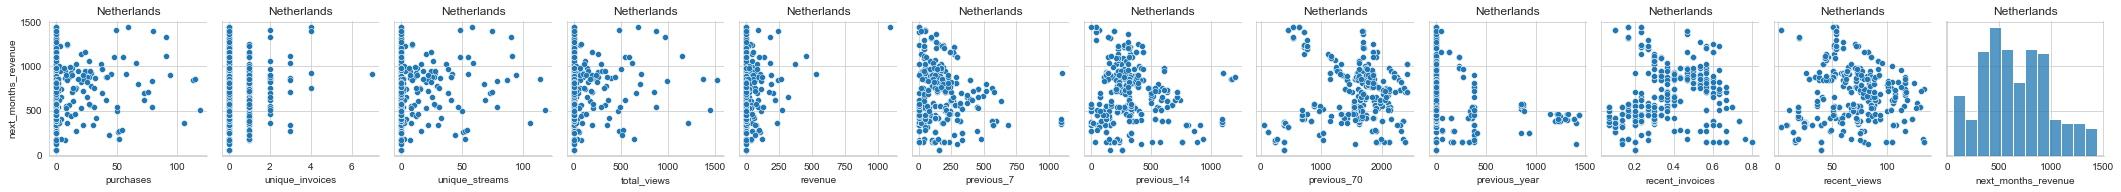

In [27]:
for country in top_ten_countries.index:
    g = sns.pairplot(x_vars=names,y_vars="next_months_revenue", data=df_train[df_train["country"]==country])
    g.set(title=country)
